In [ ]:
# Ensure consistency across runs
from numpy.random import seed
import random

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

import os

import tensorflow as tf
import tensorflow_datasets as tfds

#Convoluted Neural Networks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential, load_model, Model

In [ ]:
print(tf.__version__)

2.4.1


### The directory contains folders of each letter including another aspect of space. All these folders will be considered as classes.

In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/Datasets/Training Set"))

['P', 'E', 'V', 'X', 'K', 'B', 'W', 'Y', 'L', 'Q', 'A', 'F', 'M', 'D', 'C', 'space', 'H', 'S', 'J', 'O', 'R', 'N', 'G', 'U', 'I', 'T', 'Z']


In [ ]:
classes= os.listdir("/content/drive/MyDrive/Datasets/Training Set")
num_classes=len(classes)
print(num_classes)

27


In [ ]:
batch_size = 32
img_height = 25
img_width = 25

In [ ]:
data_dir='/content/drive/MyDrive/Datasets/Training Set'

## **Separating the dataset into training and testing dataset**

### Divide the validation split when developing your model. Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 77554 files belonging to 27 classes.
Using 62044 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 77554 files belonging to 27 classes.
Using 15510 files for validation.


### You can find the class names in the class_names attribute on these datasets.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']


## **Visualize the Data**

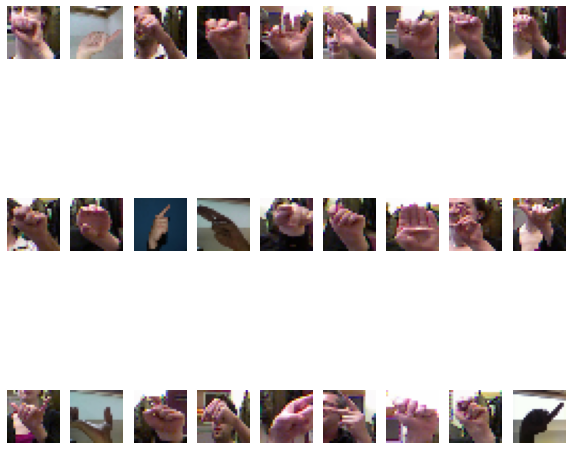

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(27):
    ax = plt.subplot(3, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 25, 25, 3)
(32, 27)


### The image_batch is a tensor of the shape (32, 25, 25, 3). This is a batch of 32 images of shape 25x25x3.

### The label_batch is a tensor of the shape (32,27), these are the corresponding labels to the 32 images and 27 indicates the 27 classes which have been encoded.

### The RGB channel values are in the [0, 255] range. It is not ideal for a neural network and inputs should be small for lesser time computation. So the inputs are standardized from [0,1]

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

### The inputs are standardized to dataset by calling the map.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027450982 0.7490196


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## **Train the model**

In [ ]:
model = Sequential()   

In [ ]:
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (25, 25, 3)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(27, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 25, 25, 64)        4864      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 128)         409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 128)        

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=7)

Epoch 1/7
1939/1939 [==============================] - 5993s 3s/step - loss: 3.3253 - accuracy: 0.0479 - val_loss: 2.9239 - val_accuracy: 0.1684
Epoch 2/7
1939/1939 [==============================] - 169s 87ms/step - loss: 2.5924 - accuracy: 0.2154 - val_loss: 1.2581 - val_accuracy: 0.6171
Epoch 3/7
1939/1939 [==============================] - 171s 88ms/step - loss: 1.5727 - accuracy: 0.5047 - val_loss: 1.1510 - val_accuracy: 0.6655
Epoch 4/7
1939/1939 [==============================] - 173s 89ms/step - loss: 1.3185 - accuracy: 0.5938 - val_loss: 0.9528 - val_accuracy: 0.7248
Epoch 5/7
1939/1939 [==============================] - 174s 90ms/step - loss: 1.2101 - accuracy: 0.6298 - val_loss: 0.7284 - val_accuracy: 0.7847
Epoch 6/7
1939/1939 [==============================] - 173s 89ms/step - loss: 1.1235 - accuracy: 0.6620 - val_loss: 0.6419 - val_accuracy: 0.8044
Epoch 7/7
1939/1939 [==============================] - 178s 91ms/step - loss: 1.0564 - accuracy: 0.6842 - val_loss: 0.6434 - 

In [ ]:
test_loss, test_acc=model.evaluate(val_ds,verbose=5)

In [ ]:
test_loss

0.6433544158935547

In [ ]:
test_acc

0.8108317255973816

In [ ]:
pred = model.predict(val_ds) 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs_range = range(7)

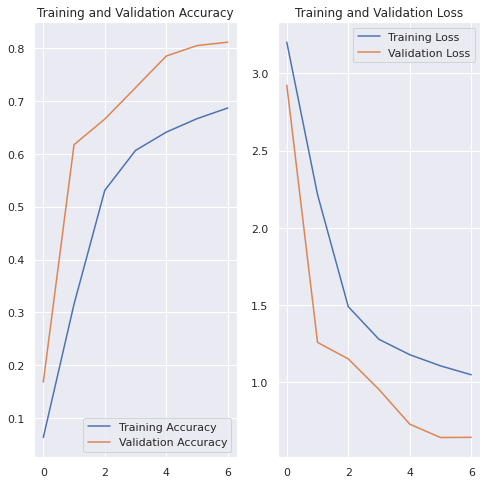

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
asl-z_url = "https://ih1.redbubble.net/image.753014913.0629/flat,750x,075,f-pad,750x1000,f8f8f8.u1.jpg"
asl-z_path = tf.keras.utils.get_file('Red_sunflower', origin=asl-z_url)

img = keras.preprocessing.image.load_img(
    asl-z_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Z with a 3.81 percent confidence.
